# V01 - Proyecto Parte 1
Carga de datos y primer acercamiento al procesamiento<br>
***Objetivo:** Crear un modelo de machine learning que siga la estrategia **US30C.Cash_strategy**<br> metrica objetivo 'precisión' (al menos 0.80)<br>
El proyecto se divide en varias partes<br>
En esta parte del proyecto se prepararán los datos para el entrenamiento del modelo, para esto:
- Se transformarán la zona horaría del dataset origen
- Se generarán operaciones ficticias.
- Se guardarán los datos para su posterior analisis



**Importamos librerias**

In [16]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('dark_background')
import plotly.graph_objects as go
from plotly.subplots import make_subplots

**Cargamos los datos**
- Tenemos que localizar el horario en el que están los datos.
- Transformarlos a nuestra zona horaria.

In [2]:
#LOAD DATA
data=pd.read_csv('../Datos/US30.cash_data_m1_antiguo.csv',index_col=0,parse_dates=True)

## PROCESAMIENTO DE LOS DATOS

En este dataset debemos agregar cualquier información relevante<br>
Pasos a seguir:<br>
**Paso 1:** Cambiamos la zona horaria<br>
**Paso 2:** creamos columnas con Hour, Minute y DayOfYear<br>
**Paso 3:** Cremos el resto de columnas target<br>

In [3]:

#-----------------------------------------PASO 1-----------------------------------------
data.index=data.index.tz_localize('Etc/GMT-3')#Localizamos el horario en el que se encuentran los datos en MetaTrader5
data.index=data.index.tz_convert('Etc/GMT+5').tz_localize(None)# Al final eliminamos la zona horaria del índice
#-----------------------------------------PASO 2-----------------------------------------
data['DayOfYear'] = data.index.dayofyear#Creamos una columna con el dia del año del índice
data['Hour']=data.index.hour#Creamos una columna con la hora del índice
data['Minute']=data.index.minute#Creamos una columna con los minutos del índice



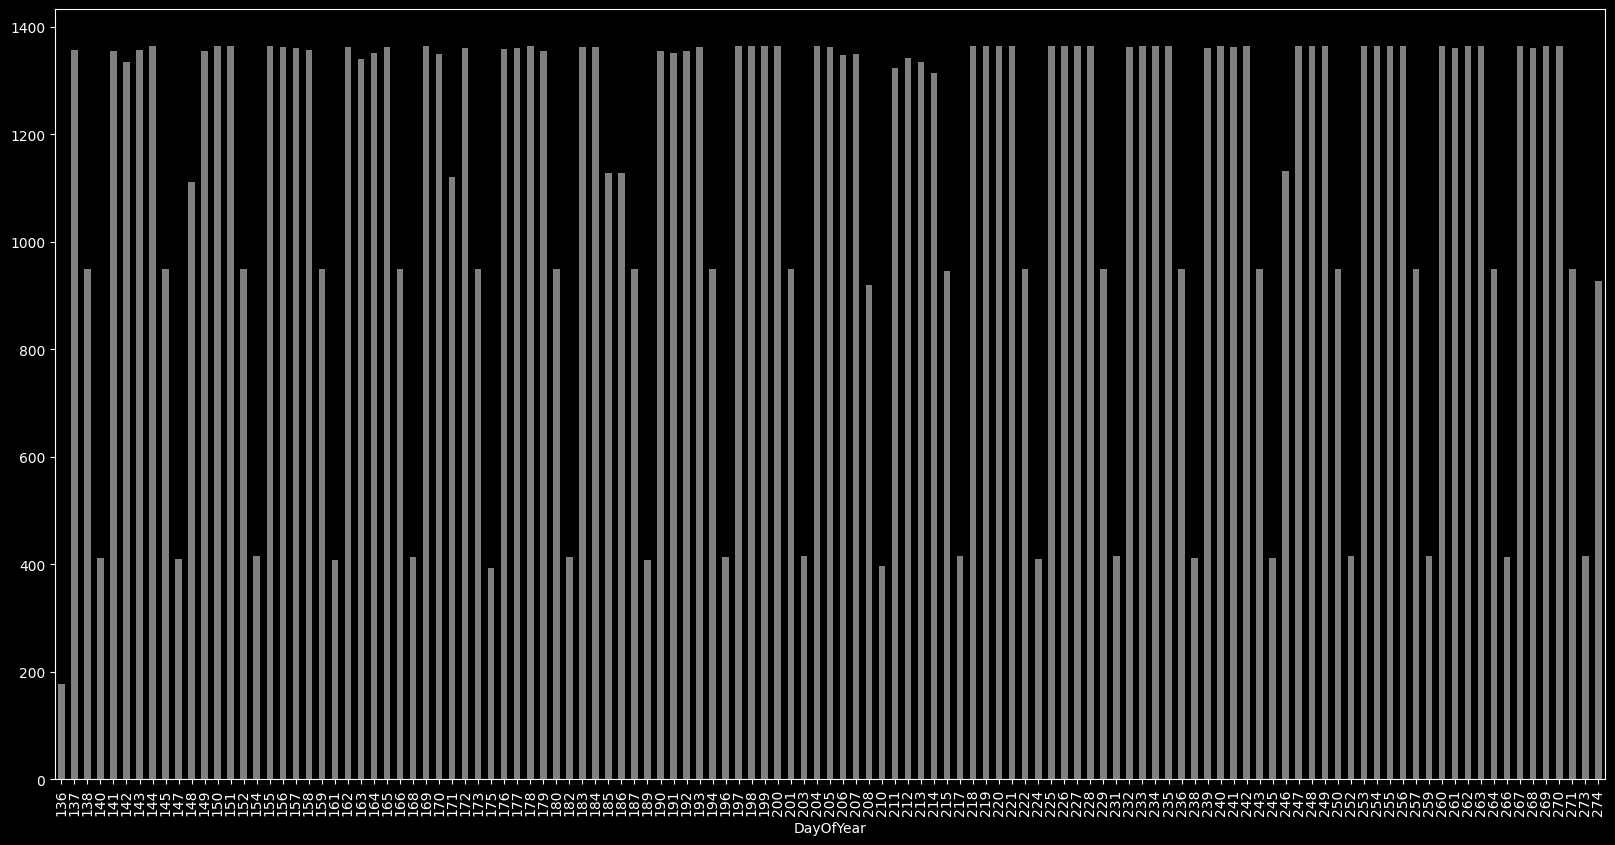

In [4]:
data.groupby('DayOfYear').size().plot(kind='bar',figsize=(20,10),color='grey')
plt.show()

Podemos notar que tenemos "x" días en nuestro dataset, cada día con un número de velas:
El primer día muy pocas, porque no se recolectaron correctamente. De ahí en adelante:

| Día              | Intervalo                | Número de velas |
|------------------|--------------------------|-----------------|
| Los días Domingo | 17:05:00 - 23:59:00      | 415  velas      |
| Lunes-Jueves     | 00:00:00 - 23:59:00      | 1365 velas      |
| Viernes          | 00:00:00 - 15:49:00      | 950  velas      |

El ultimo día tambien vemos que no esta completo, es normal, debido a la descarga de datos.<br>
**Nota:** Algunos días del año contamos con menos observaciones como por ejemplo el día **148,171,185,186,248,etc**, es debido a decisiones del mercado al cerrarse.<br>
- Se cierra desde las 12:00:00 horas, hasta las 17:05:00.<br>
- Puedes revisar a detalle esto seleccionando el día abajo

(1132, 10)

,open,high,low,close,tick_volume,spread,real_volume,DayOfYear,Hour,Minute
time,,,,,,,,,,
2024-09-02 00:00:00,41530.15,41530.65,41529.15,41529.15,10.0,220,0.0,246,0,0
2024-09-02 00:01:00,41530.15,41531.15,41530.05,41530.05,6.0,220,0.0,246,0,1
2024-09-02 00:02:00,41530.05,41532.15,41530.05,41532.15,9.0,210,0.0,246,0,2
2024-09-02 00:03:00,41532.15,41534.55,41532.15,41532.55,8.0,220,0.0,246,0,3
2024-09-02 00:04:00,41532.05,41533.05,41531.45,41532.95,7.0,240,0.0,246,0,4


,open,high,low,close,tick_volume,spread,real_volume,DayOfYear,Hour,Minute
time,,,,,,,,,,
2024-09-02 23:55:00,41470.45,41470.95,41469.95,41469.95,6.0,210,0.0,246,23,55
2024-09-02 23:56:00,41469.95,41470.45,41466.95,41467.85,6.0,210,0.0,246,23,56
2024-09-02 23:57:00,41466.85,41467.35,41465.35,41466.25,16.0,240,0.0,246,23,57
2024-09-02 23:58:00,41466.75,41467.85,41466.25,41466.85,6.0,230,0.0,246,23,58
2024-09-02 23:59:00,41467.35,41467.85,41466.85,41467.35,5.0,240,0.0,246,23,59


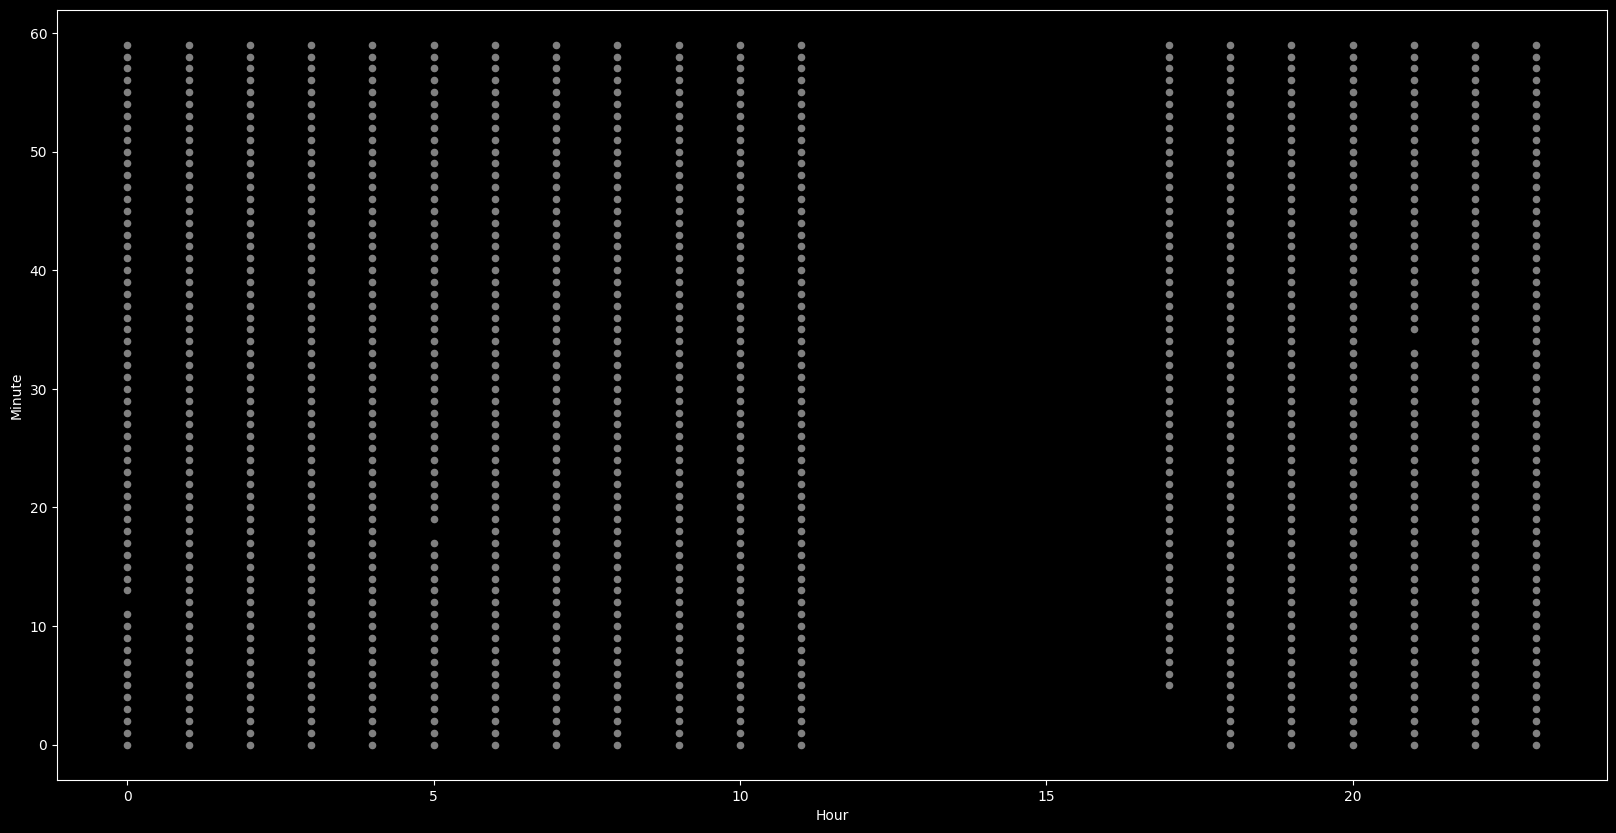

In [5]:
grupo = data.groupby('DayOfYear').get_group(246)
display(grupo.shape)
display(grupo.head())#primeras velas
display(grupo.tail())#ultimas velas
grupo.plot(kind='scatter',x='Hour',y='Minute',figsize=(20,10),color='grey')
plt.show()

Visto esto, sabemos que debemos eliminar el primer y ultimo día, el resto de la información es correcta.

In [6]:
data = data[~data['DayOfYear'].isin([data['DayOfYear'].min(),
                                     data['DayOfYear'].max()])]

**PASO 3**
Para este paso vamos a crear una función que agregue las operaciones según la estrategia:<br>
Estas operaciones se califican como ganadas (1) y perdidas (0) en tres categorias diferente 'ratio riesgo beneficio **1/3 (Tres)** , **1/2 (Dos)** y **1/1.5 (PuntoCinco)**'.<br>
- La función **agregar_columnas_operaciones** se va encargar de agregar estas columnas y rellenarlas según el resultado de la operación.
- Se toamará un día y se revisarán las operaciones realizadas para verificar que todo esta bien.
- Se realizará el proceso para el resto de días y se guardará el nuevo DataFrame como **Buys.csv** y **Sells.csv** donde:
    - **Buys.csv:** Contiene las operaciones de compra
    - **Sells.csv:** Contiene las operaciones de venta
Nota: Se tienen dos DataFrames para crear dos modelos, uno encargado de las compras y otro encargado de las ventas.


**CREACIÓN DE LA FUNCIÓN**

In [12]:
def agregar_columnas_operaciones(df):
    # Asegurarse de que el DataFrame esté ordenado cronológicamente
    df = df.sort_values(by=['DayOfYear', 'Hour', 'Minute']).reset_index(drop=False)
    
    # Inicializar las nuevas columnas con NaN
    df['Tres'] = np.nan
    df['Dos'] = np.nan
    df['PuntoCinco'] = np.nan

    # Definir los factores de multiplicación para cada columna
    factores = {
        'Tres': 3,
        'Dos': 2,
        'PuntoCinco': 1.5
    }
    
    # Convertir las columnas de tiempo a minutos totales para facilitar cálculos
    df['TotalMinutes'] = df['DayOfYear'] * 1440 + df['Hour'] * 60 + df['Minute']
    
    n = len(df)
    
    # Iterar sobre cada fila del DataFrame
    for i in range(n):
        buy = df.at[i, 'Buy']
        open_price = df.at[i, 'open']
        day = df.at[i, 'DayOfYear']
        time = df.at[i, 'TotalMinutes']
        
        # Parámetros fijos
        StopLoss = 30
        
        # Para cada columna a calcular
        for col, factor in factores.items():
            if pd.notna(df.at[i, col]):
                continue  # Ya procesado
            
            # Calcular SL_price y TP_price
            if buy == 1:
                SL_price = open_price - StopLoss
                TP_price = open_price + StopLoss * factor
            else:
                SL_price = open_price + StopLoss
                TP_price = open_price - StopLoss * factor
            
            # Buscar en las observaciones siguientes
            j = i + 1
            operacion_cerrada = False
            while j < n:
                # Verificar cambio de día o tiempo máximo de 60 minutos
                current_day = df.at[j, 'DayOfYear']
                current_time = df.at[j, 'TotalMinutes']
                elapsed_time = current_time - time
                if current_day != day or elapsed_time >= 60:
                    # Operación cerrada por tiempo, se considera pérdida
                    df.at[i, col] = 0
                    operacion_cerrada = True
                    break
                
                high = df.at[j, 'high']
                low = df.at[j, 'low']
                
                if buy == 1:
                    if high >= TP_price:
                        df.at[i, col] = 1  # Ganó
                        operacion_cerrada = True
                        break
                    elif low <= SL_price:
                        df.at[i, col] = 0  # Perdió
                        operacion_cerrada = True
                        break
                else:
                    if low <= TP_price:
                        df.at[i, col] = 1  # Ganó
                        operacion_cerrada = True
                        break
                    elif high >= SL_price:
                        df.at[i, col] = 0  # Perdió
                        operacion_cerrada = True
                        break
                j += 1
            
            if not operacion_cerrada:
                # Si no se cerró la operación dentro del DataFrame, se considera pérdida
                df.at[i, col] = 0
    
    # Opcional: eliminar la columna temporal 'TotalMinutes'
    df.drop(columns=['TotalMinutes'], inplace=True)
    
    return df


**DIA DE PRUEBA**

In [26]:

Buys=data[data['DayOfYear']==143].copy()
Sells=data[data['DayOfYear']==143].copy()
Buys['Buy']=1
Sells['Buy']=0

In [27]:
Buys = agregar_columnas_operaciones(Buys)

In [28]:


# Crear la figura con subplots
fig = make_subplots(rows=1, cols=1)

# Añadir gráfico de velas
fig.add_trace(go.Candlestick(
    x=Buys['time'],
    open=Buys['open'],
    high=Buys['high'],
    low=Buys['low'],
    close=Buys['close'],
    name='Candlesticks'
))
# Actualizar layout
fig.update_layout(
    title=f"Operaciones del día x",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False
)
for index, fila in Buys.iterrows():
    entry_time = fila['time']
    entry_price = fila['open']
    exit_time = entry_time + pd.Timedelta(minutes=60)
    SL = entry_price - 30
    
    # Convertir las columnas 'Tres', 'Dos', 'PuntoCinco' en una lista
    lista_op = fila[['Tres', 'Dos', 'PuntoCinco']].tolist()

    # Iterar sobre los índices de la lista
    for n in range(len(lista_op)):
        if lista_op[n] == 1:
            # Asignar TP en función del valor de 'n'
            if n == 0:
                TP = entry_price + 30 * 3
            elif n == 1:
                TP = entry_price + 30 * 2
            elif n == 2:
                TP = entry_price + 30 * 1.5
            
            # Dibujar SL (Stop Loss)
            fig.add_shape(type="rect",
                          x0=entry_time, x1=exit_time,
                          y0=entry_price, y1=SL,
                          fillcolor="red",
                          opacity=0.1,
                          line=dict(color="white"))
            
            # Dibujar TP (Take Profit)
            fig.add_shape(type="rect",
                          x0=entry_time, x1=exit_time,
                          y0=entry_price, y1=TP,
                          fillcolor="green",
                          opacity=0.1,
                          line=dict(color="white"))

fig.show()

In [34]:
print('En total se pintaron {} operaciones'.format(Buys[Buys['PuntoCinco']==1].shape[0]))

En total se pintaron 229 operaciones


**EJECUCIÓN DEL AGREGADO COMPLETO DE DATOS**

In [35]:
Buys_final=data.copy()
Sells_final=data.copy()
Buys_final['Buy']=1
Sells_final['Buy']=0
Buys_final = agregar_columnas_operaciones(Buys_final)
Sells_final = agregar_columnas_operaciones(Sells_final)
#Culminación esperado del proceso: 8 minutos

La generación de los datos tiene un alto costo computacional, por esta razón guardamos los resultados como arcivos **.csv**

In [39]:
Buys_final.to_csv('Buys.csv', index=False)
Sells_final.to_csv('Sells.csv', index=False)